In [1]:
# Notebook hücresinde bu şekilde kullanın:

# 1. sampling modülü
from stats_for_mols.sampling import DataSplitter

# 2. performance modülü (başındaki noktayı kaldırdık)
from stats_for_mols.performance.metrics import MetricCalculator

# 3. statistics modülü (başındaki noktayı kaldırdık)
from stats_for_mols.statistics import StatisticalValidator

# 4. visualization modülü (başındaki noktaları kaldırdık)
from stats_for_mols.visualization.plots import plot_mcsim, plot_simultaneous_ci
from stats_for_mols.visualization.metrics_plot import MetricVisualizer
from stats_for_mols.visualization.diagnostics import plot_target_distribution

/nfs/home/myuecel3/stats_for_mols/.venv/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
plt.style.use('seaborn-v0_8-whitegrid')
np.random.seed(42)

In [3]:
# Create synthetic data
X, y = make_regression(n_samples=1000, n_features=1024, n_informative=50, noise=0.5, random_state=42)

# Convert to DataFrame
df = pd.DataFrame(X, columns=[f'fp_{i}' for i in range(1024)])
df['pIC50'] = y  # Target variable (e.g., pIC50)

# Add dummy SMILES column to demonstrate API compatibility
# (In real usage, you would load a CSV with real SMILES)
df['SMILES'] = ["C" * np.random.randint(1, 10) for _ in range(1000)]

print(f"Dataset Shape: {df.shape}")
print("Target Range:", df['pIC50'].min(), "to", df['pIC50'].max())

Dataset Shape: (1000, 1026)
Target Range: -1263.1601714664157 to 1587.2723406075672


Selected Strategy: repeated_cv
Splits: 5, Repeats: 5
Using repeated_cv with 5 splits and 5 repeats.


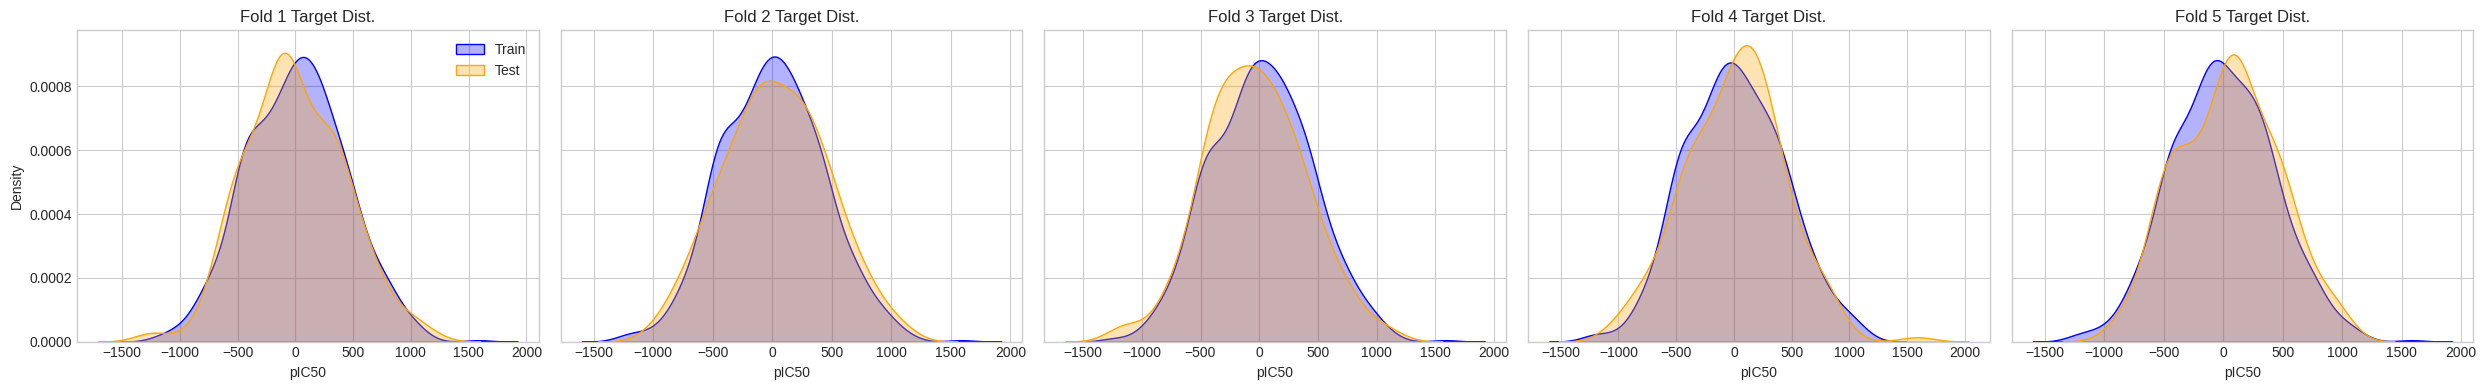

In [ ]:
# Initialize Splitter
# Note: Use 'scaffold' if you have real SMILES.
# For this synthetic demo, we use 'random'.
splitter = DataSplitter(df, target_col='pIC50', split_type='random', task_type='regression')

print(f"Selected Strategy: {splitter.config['method_name']}")
print(f"Splits: {splitter.config['n_splits']}, Repeats: {splitter.config['n_repeats']}")

# Diagnostic Plot: Check if target distribution is preserved across folds
plot_target_distribution(df, 'pIC50', splitter)
plt.show()

In [5]:
# Define Models
models = {
    'DecisionTree': DecisionTreeRegressor(random_state=42),
    'RandomForest': RandomForestRegressor(n_estimators=50, n_jobs=-1, random_state=42),
    'XGBoost': GradientBoostingRegressor(n_estimators=50, random_state=42) # Using sklearn GBM as proxy
}

results_list = []
raw_predictions = [] # To store y_true vs y_pred for visualization

print("Starting 5x5 Repeated CV...")

# The Splitter Loop
for i, (train_idx, test_idx) in enumerate(splitter.split()):
    
    # Create Subsets
    X_train, y_train = df.iloc[train_idx].drop(columns=['pIC50', 'SMILES']), df.iloc[train_idx]['pIC50']
    X_test, y_test = df.iloc[test_idx].drop(columns=['pIC50', 'SMILES']), df.iloc[test_idx]['pIC50']
    
    for name, model in models.items():
        # Train
        model.fit(X_train, y_train)
        
        # Predict
        y_pred = model.predict(X_test)
        
        # Calculate Metrics (using our domain-specific calculator)
        # We request Top-10% ranking metrics which is crucial for drug discovery
        metrics = MetricCalculator.get_regression_metrics(y_test.values, y_pred, top_k_fractions=[0.1])
        
        # Store Summary
        res = {'model': name, 'fold': i}
        res.update(metrics)
        results_list.append(res)
        
        # Store Raw Predictions (for Scatter plots later)
        if i == 0: # Only store first fold to save memory for demo
            raw_predictions.append(pd.DataFrame({'model': name, 'y_true': y_test.values, 'y_pred': y_pred}))

# Convert to DataFrame
results_df = pd.DataFrame(results_list)
print("Training Complete.")
results_df.head()

Starting 5x5 Repeated CV...
Using repeated_cv with 5 splits and 5 repeats.
Training Complete.


,model,fold,MAE,RMSE,R2,Pearson_Global,Spearman_Global,Kendall_Global,Spearman_Top10%,Kendall_Top10%
0,DecisionTree,0,399.201230,514.175560,-0.434631,0.288126,0.289687,0.196811,-0.023343,-0.031917
1,RandomForest,0,310.809352,390.066355,0.174353,0.446954,0.466402,0.318191,0.351880,0.200000
2,XGBoost,0,262.702683,327.211005,0.419004,0.724012,0.734586,0.534874,0.410526,0.305263
3,DecisionTree,1,453.727584,559.699647,-0.602471,0.181334,0.194563,0.128922,-0.076749,-0.063493
4,RandomForest,1,315.811318,388.133862,0.229375,0.543252,0.536035,0.368744,-0.341353,-0.242105


In [13]:
results_df.describe()
results_df

,model,fold,MAE,RMSE,R2,Pearson_Global,Spearman_Global,Kendall_Global,Spearman_Top10%,Kendall_Top10%
0,DecisionTree,0,399.201230,514.175560,-0.434631,0.288126,0.289687,0.196811,-0.023343,-0.031917
1,RandomForest,0,310.809352,390.066355,0.174353,0.446954,0.466402,0.318191,0.351880,0.200000
2,XGBoost,0,262.702683,327.211005,0.419004,0.724012,0.734586,0.534874,0.410526,0.305263
3,DecisionTree,1,453.727584,559.699647,-0.602471,0.181334,0.194563,0.128922,-0.076749,-0.063493
4,RandomForest,1,315.811318,388.133862,0.229375,0.543252,0.536035,0.368744,-0.341353,-0.242105
...,...,...,...,...,...,...,...,...,...,...
70,RandomForest,23,305.639388,371.378669,0.264723,0.617783,0.594484,0.427839,0.436090,0.294737
71,XGBoost,23,265.294122,319.340076,0.456344,0.748677,0.742063,0.547940,0.096241,0.073684
72,DecisionTree,24,486.429301,598.357851,-0.812380,0.107768,0.078009,0.049298,0.692080,0.462473
73,RandomForest,24,323.765923,406.355596,0.164128,0.450971,0.460603,0.319296,0.222556,0.157895


In [7]:
# Initialize Validator
validator = StatisticalValidator(results_df, model_col='model', score_col='RMSE', subject_col='fold')

# Run Validation
stats_report = validator.validate()

print(f"--- Statistical Report ---")
print(f"Assumptions Met: {stats_report['assumptions']['valid_parametric']}")
print(f"Test Used: {stats_report['global_test']}")
print(f"Global p-value: {stats_report['global_pvalue']:.2e}")

# If significant, show pairwise comparisons
if stats_report['global_pvalue'] < 0.05:
    print("\nPairwise Comparisons (Differences):")
    display(stats_report['pairwise_results'])

Sphericity test failed. Assuming violation of sphericity.
Assumptions violated (Normality=True, Sphericity=False). Running Non-Parametric Tests (Friedman).
--- Statistical Report ---
Assumptions Met: False
Test Used: Friedman Test
Global p-value: 1.39e-11

Pairwise Comparisons (Differences):


,A,B,mean(A),mean(B),diff,p-tukey,test
0,DecisionTree,RandomForest,559.307123,378.340591,180.966532,1.163190e-17,Conover
1,DecisionTree,XGBoost,559.307123,323.285914,236.021209,9.167329e-34,Conover
2,RandomForest,XGBoost,378.340591,323.285914,55.054677,5.430303e-17,Conover


/nfs/home/myuecel3/stats_for_mols/stats_for_mols/visualization/plots.py:126: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot_matrix = p_matrix.applymap(get_star)


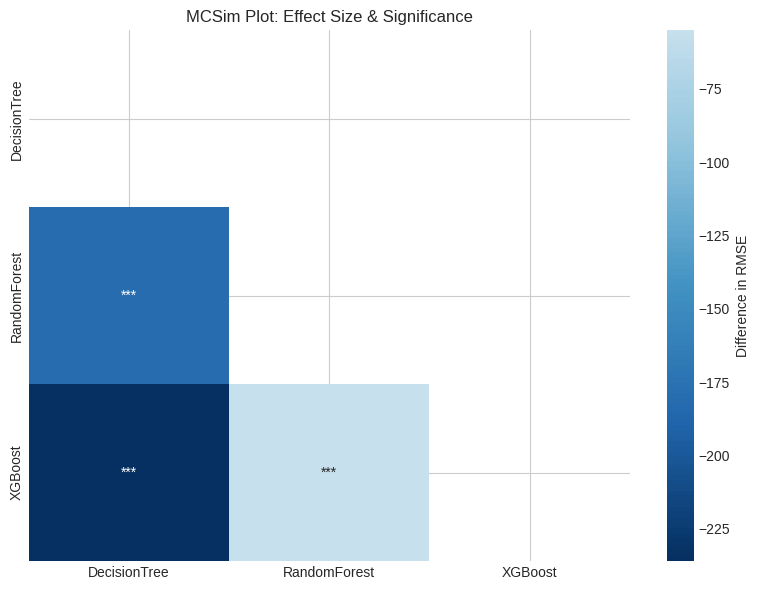

KeyError: 'Comparison'

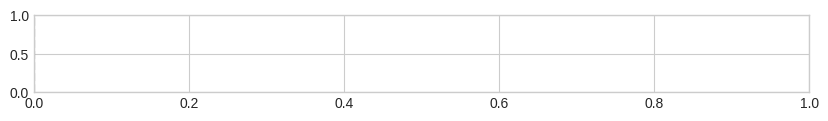

In [8]:
# 1. MCSim Plot (Multiple Comparisons Similarity)
# Shows which models are statistically similar (grey/white) vs different (colored)
# Stars indicate significance level (* p<0.05)
plot_mcsim(stats_report['pairwise_results'], metric_name='RMSE')
plt.show()

# 2. Simultaneous Confidence Intervals
# Shows the 95% Confidence Interval of the difference between the Best Model and others.
# If the interval does not cross zero, the difference is significant.
plot_simultaneous_ci(stats_report['pairwise_results'], metric_name='RMSE')
plt.show()

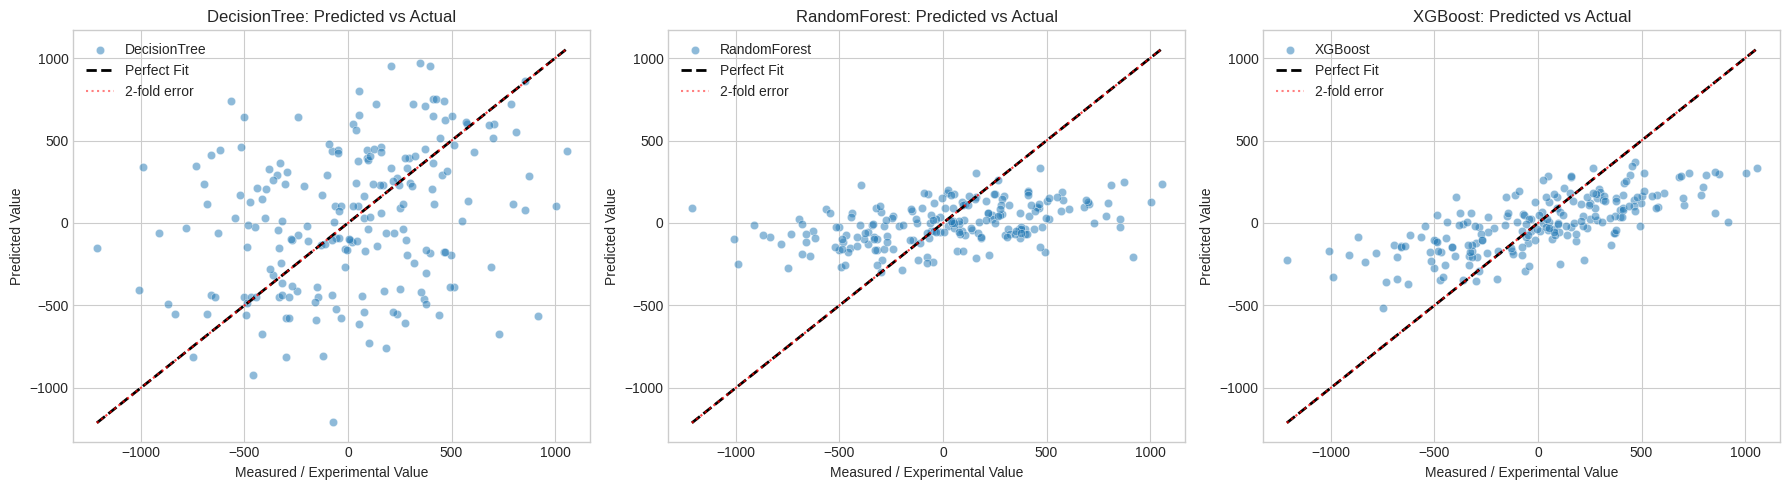

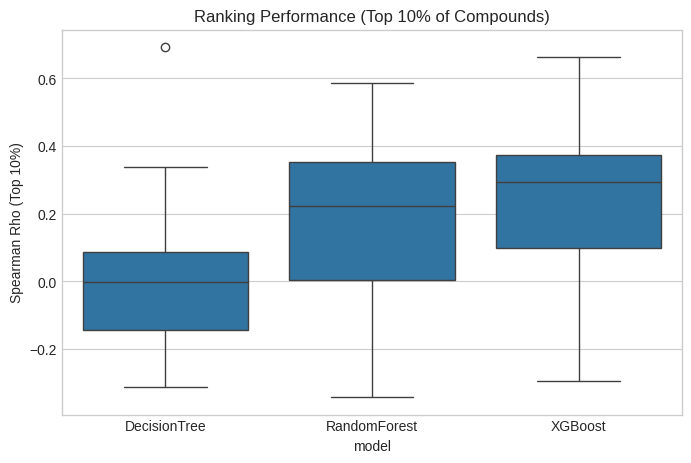

In [9]:
# Visualize Raw Predictions for the first fold
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, name in enumerate(models.keys()):
    subset = pd.concat(raw_predictions)
    subset = subset[subset['model'] == name]
    
    # Use our MetricVisualizer to draw the identity line and 2-fold error margins
    MetricVisualizer.plot_regression_scatter(subset['y_true'], subset['y_pred'], model_name=name, ax=axes[idx])

plt.tight_layout()
plt.show()

# Check Ranking Performance (Spearman Top 10%)
# This tells us: "How good is the model at ranking the best compounds?"
plt.figure(figsize=(8, 5))
import seaborn as sns
sns.boxplot(data=results_df, x='model', y='Spearman_Top10%')
plt.title("Ranking Performance (Top 10% of Compounds)")
plt.ylabel("Spearman Rho (Top 10%)")
plt.show()